# Сборный проект 2


## Задачи проекта 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.


## Описание данных

Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from scipy import stats as st
import math as mth
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/Users/aleksandrgrisenkin/Desktop/df/10. Анализ пользовательского поведения в мобильном приложении/logs_exp.csv', sep = '\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
df.isna().mean().apply('{:.0%}'.format)

EventName         0%
DeviceIDHash      0%
EventTimestamp    0%
ExpId             0%
dtype: object

### Вывод о данных :

Нужно:
заменить названия столбцов и перевести в нижний регистр;

Проверить на дубликаты;

Поменять типы данных "EventTimestamp";



In [6]:
df.columns = ['event_name', 'uid', 'timestamp_unix', 'group']

In [7]:
display("Дубликатов в df: {} ({:.1%} от общего размера df)".format(
    df.duplicated().sum(),
    df.duplicated().sum() / len(df)
)
     )

'Дубликатов в df: 413 (0.2% от общего размера df)'

В df 413 дубликатов, это всего 0,2%. Можно удалить. Но обязательно передать информацию в соответсвующее подразделение.

In [8]:
df.drop_duplicates(
    inplace=True,
)

df.reset_index(
    inplace=True, 
    drop=True
)

#### Добавьте столбец даты и времени, а также отдельный столбец дат;


In [9]:
df['timestamp_unix'] = pd.to_datetime(
    df['timestamp_unix'],
    unit='s'
)

In [10]:
df['timestamp'] = df['timestamp_unix'] + pd.Timedelta(hours=3) 

In [11]:
df['date'] = df['timestamp'].astype('datetime64[D]')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   uid             243713 non-null  int64         
 2   timestamp_unix  243713 non-null  datetime64[ns]
 3   group           243713 non-null  int64         
 4   timestamp       243713 non-null  datetime64[ns]
 5   date            243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


In [13]:
df.head(5)

,event_name,uid,timestamp_unix,group,timestamp,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 07:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 14:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 14:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 14:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 14:48:42,2019-07-25


#### Сколько всего событий в логе?


In [14]:
display('Всего событий %d, типов событий %d.' % (df.shape[0], df['event_name'].nunique()))

'Всего событий 243713, типов событий 5.'

In [15]:
df.groupby('event_name')['date'].count().sort_values(ascending=False)

event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: date, dtype: int64

Назначение события

MainScreenAppear - "Появился Главный Экран"

PaymentScreenSuccessful - "Экран Оплаты Прошел Успешно"

CartScreenAppear - "Появился Экран Корзины"

OffersScreenAppear - "Появился Экран Предложений"

Tutorial - "Руководство"

Пользователь открыл главный экран - Открыл экран предложений - Открыл экран корзины - Экран оплаты прошел успешно. В руководство можно (скорее всего) перейти с любого этапа.

Всего 5 событий. MainScreenAppear - больше всего событий.

#### Сколько всего пользователей в логе?

In [16]:
display('Всего пользователей в логе %d.' % (df['uid'].nunique()))

'Всего пользователей в логе 7551.'

#### Сколько в среднем событий приходится на пользователя?

In [17]:
display('В среднем событий на пользователя %d.' % (df.shape[0] / df['uid'].nunique()))

'В среднем событий на пользователя 32.'

In [18]:
display('Медианное количество событий  на пользователя %d.' % (df.groupby('uid')['event_name'].count().median()))

'Медианное количество событий  на пользователя 20.'

#### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Данными за какой период времени вы располагаете на самом деле?

In [19]:
df_logs_exp_period = df['timestamp'].describe()

In [20]:
print('Анализ периода выгрузки лога.')
print("Минимальная дата: {:%d.%m.%Y} \n\
Максимальная дата: {:%d.%m.%Y} \n\
Период: {:.1f} дней \n\
".format(
    df_logs_exp_period['first'],
    df_logs_exp_period['last'],
    (df_logs_exp_period['last'] - df_logs_exp_period['first']) / np.timedelta64(1, 'D')
    
))

Анализ периода выгрузки лога.
Минимальная дата: 25.07.2019 
Максимальная дата: 08.08.2019 
Период: 13.7 дней 



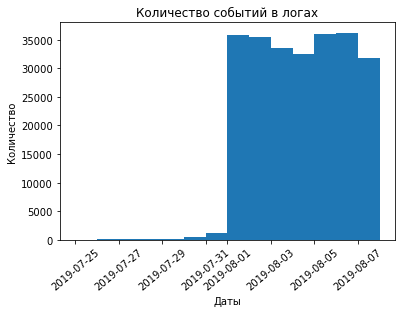

In [21]:
plt.hist(df['date'], bins=14)
plt.xticks(rotation = 40)
plt.xlabel('Даты')
plt.ylabel('Количество')

plt.title('Количество событий в логах')

plt.show()

In [22]:
df.groupby('date')['uid'].count()

date
2019-07-25        9
2019-07-26       30
2019-07-27       55
2019-07-28      104
2019-07-29      181
2019-07-30      397
2019-07-31     1213
2019-08-01    35767
2019-08-02    35571
2019-08-03    33602
2019-08-04    32583
2019-08-05    36075
2019-08-06    36270
2019-08-07    31788
2019-08-08       68
Name: uid, dtype: int64

Проанализировав график можно сделать вывод, что количество событий июля и августа сильно отличаются.

Исходя из вышеизложенного оставляем 7 дней августа с 2019-08-01 по 2019-08-07.

#### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [23]:
df_filter = df[(df['date'] >= '2019-08-01')&(df['date'] < '2019-08-08')]

In [24]:
df_filter.groupby('date')['uid'].count()

date
2019-08-01    35767
2019-08-02    35571
2019-08-03    33602
2019-08-04    32583
2019-08-05    36075
2019-08-06    36270
2019-08-07    31788
Name: uid, dtype: int64

In [25]:
print('Отрезал {} строк в данных. Остались данные за период с {:%d.%m.%Y} по {:%d.%m.%Y}. Всего {:.1f} дней'.format(
    df.shape[0] - df_filter.shape[0], 
    df_filter['date'].min(), 
    df_filter['date'].max(),
    (df_filter['date'].max() - df_filter['date'].min())// np.timedelta64(1, 'D')
        )
     )

Отрезал 2057 строк в данных. Остались данные за период с 01.08.2019 по 07.08.2019. Всего 6.0 дней


In [26]:
display('Всего событий после среза %d, типов событий %d.' % (df_filter.shape[0], df_filter['event_name'].nunique()))

'Всего событий после среза 241656, типов событий 5.'

In [27]:
display('Всего пользователей в после среза %d.' % (df_filter['uid'].nunique()))

'Всего пользователей в после среза 7538.'

### Вывод 

Отбросив старые данные мы потеряли, 2148 событий и 13 пользователей, это менее 1%. 


#### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.


In [28]:
df_filter.groupby('event_name')['uid'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117850
OffersScreenAppear          46509
CartScreenAppear            42338
PaymentScreenSuccessful     33949
Tutorial                     1010
Name: uid, dtype: int64

#### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [29]:
users_funnel = df_filter.groupby('event_name').agg({'uid': 'nunique'}).sort_values(by='uid',ascending=False).reset_index()

In [30]:
users_funnel

,event_name,uid
0,MainScreenAppear,7423
1,OffersScreenAppear,4596
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


In [31]:
users_funnel['total_%'] =round( users_funnel['uid']*100 / df_filter['uid'].nunique())

In [32]:
users_funnel

,event_name,uid,total_%
0,MainScreenAppear,7423,98.0
1,OffersScreenAppear,4596,61.0
2,CartScreenAppear,3736,50.0
3,PaymentScreenSuccessful,3540,47.0
4,Tutorial,843,11.0


#### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События выстраиваються в последовательную цепочку. Похоже на воронку продаж. Надо понимать, что в Tutorial можно попасть с любой страници.

#### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [33]:
users_funnel['funnel_%'] = (users_funnel.uid.pct_change() + 1)*100

In [34]:
users_funnel = users_funnel.query('event_name != "Tutorial"')


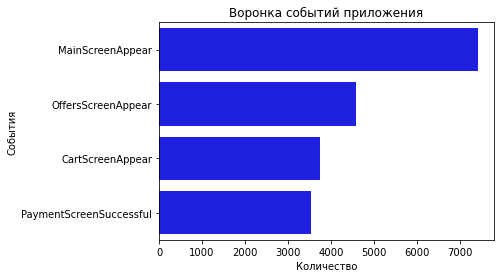

In [35]:
sns.barplot(x='uid', y='event_name', data=users_funnel, color='blue') 

plt.xlabel('Количество')
plt.ylabel('События')
plt.title('Воронка событий приложения')

plt.show()

Хорошая конверсия почти 50% процентов доходят до "экрана оплаты". \
Переход по шагам пользователей высокий. С каждым шагом процент перехода увеличиваеться. Видимо продукты питания нравятсья пользователям. 

Болше всего пользователей теряем на первом этапе почти 40%. Далее с каждым шагом конверсия увеличиваеться. До экрана оплаты доходит 47% пользователей.


#### Сколько пользователей в каждой экспериментальной группе?

In [36]:
users_events = df_filter.pivot_table(index='group', columns='event_name', values = 'uid', aggfunc = 'nunique').reset_index()
users_events

event_name,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1239,2479,1523,1158,284
2,248,1231,2494,1531,1182,281


In [37]:
users_count = df_filter.groupby('group')['uid'].nunique()
users_events['count'] = users_events['group'].apply(lambda x: users_count.loc[x])
users_events = users_events.set_index('group')

In [38]:
group_246 = df_filter.loc[df_filter['group'] == 246]
users_count_246 = group_246.groupby('uid').agg({'uid': 'nunique'}).count().sum() 
group_247 = df_filter.loc[df_filter['group'] == 247]
users_count_247 = group_247.groupby('uid').agg({'uid': 'nunique'}).count().sum()
group_248 = df_filter.loc[df_filter['group'] == 248]
users_count_248 = group_248.groupby('uid').agg({'uid': 'nunique'}).count().sum()
total_user = df_filter.groupby('uid').agg({'uid': 'nunique'}).sum()

print('Количество пользователей:' 
      '\n в контрольных группе 246 - {},'     
      '\n в контрольных группе 247 - {},' 
      '\n в экспериментальной группе 248 - {}'
      .format(users_count_246, users_count_247, users_count_248))
print()
print('Группа 247 больше группы 246 на {:3.2f} процентов'.format(100 - users_count_246 * 100 / users_count_247))
print()
print('Группа 248 больше группы 246 на {:3.2f} процентов'.format(100 - users_count_246 * 100 / users_count_248))
print()
print('Группа 248 больше группы 247 на {:3.2f} процентов'.format(100 - users_count_247 * 100 / users_count_248))

Количество пользователей:
 в контрольных группе 246 - 2484,
 в контрольных группе 247 - 2517,
 в экспериментальной группе 248 - 2537

Группа 247 больше группы 246 на 1.31 процентов

Группа 248 больше группы 246 на 2.09 процентов

Группа 248 больше группы 247 на 0.79 процентов


In [39]:
print('Количество пользователей пересекающихся группы 246 с 247 - ', 
      group_246[group_246['uid'].isin(group_247['uid'])].shape[0])

print('Количество пользователей пересекающихся группы 247 с 246 - ', 
    group_248[group_248['uid'].isin(group_246['uid'])].shape[0])

print('Количество пользователей пересекающихся группы 248 с 246 - ', 
    group_248[group_248['uid'].isin(group_247['uid'])].shape[0])


Количество пользователей пересекающихся группы 246 с 247 -  0
Количество пользователей пересекающихся группы 247 с 246 -  0
Количество пользователей пересекающихся группы 248 с 246 -  0


В контрольных группах нет пересекающихся пользвоателей

In [40]:
alpha = 0.05

In [41]:
list_group = ['246', '247']
list_event = ['CartScreenAppear', 'MainScreenAppear', ]


In [42]:
def z_test(count_success1, count_success2, total_group1, total_group2):


    # пропорция успехов в первой группе:
    p1 = count_success1 / total_group1
    # пропорция успехов во второй группе:
    p2 = count_success2 / total_group2
    # пропорция успехов в комбинированном датасете:
    p_combined = (count_success1 + count_success2) / (total_group1 + total_group2)
    # разница пропорций в датасетах
    difference = p1 - p2     
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / total_group1 + 1 / total_group2)
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2    


    result = {
        'difference': difference,
        'z_value': z_value,
        'p_value': p_value,
        }  
   
    return result

Сформулируем гипотезы:\
**Нулевая гипотеза:** доли пользователей в группах 246 и 248, для всех событий одинаковые.\
**Альтернативная гипотеза:** доли пользователей в группах 246 и 248, для всех событий различаются.

**Нулевая гипотеза:** доли пользователей в группах 247 и 248, для всех событий одинаковые.\
**Альтернативная гипотеза:** доли пользователей в группах 247 и 248, для всех событий различаются.

In [46]:
users_events

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,count
group,,,,,,
246,1266,2450,1542,1200,278,2484
247,1239,2479,1523,1158,284,2517
248,1231,2494,1531,1182,281,2537


In [47]:
group_1 = users_events.loc[246] #контрольная группа
group_2 = users_events.loc[247] #контрольная группа
group_3 = users_events.loc[248] #Экперементальная группа. С измененными шрифтами

In [48]:
test_246_247 = pd.DataFrame(columns=['event', 'difference', 'z_value', 'alpha', 'p_value',  'result'])


for row in range(4):
    event = users_events.columns[row] 
    new_row = z_test(group_1[event], group_2[event], group_1['count'], group_2['count'])
    new_row['event'] = event
    
    if new_row['p_value'] < alpha:
        new_row['result'] = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'       
    else:
        new_row['result'] = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'        
    
    new_row['alpha'] = alpha
    
    test_246_247 = test_246_247.append(new_row, ignore_index=True)
    
display(test_246_247)

,event,difference,z_value,alpha,p_value,result
0,CartScreenAppear,0.017409,1.231111,0.05,0.218281,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,MainScreenAppear,0.001410,0.418445,0.05,0.675622,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,OffersScreenAppear,0.015688,1.138761,0.05,0.254803,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,PaymentScreenSuccessful,0.023020,1.630556,0.05,0.102984,"Не получилось отвергнуть нулевую гипотезу, нет..."


По результатам тестирования видим что выборки в двух контрольных группах 246 и 247 совпадают. Разбиение на группы было сделано кореектно.

Можно проводить тесты с эксперементаольной группой

**Нулевая гипотеза:** доли пользователей в группах 246 и 248, для всех событий одинаковые.\
**Альтернативная гипотеза:** доли пользователей в группах 246 и 248, для всех событий различаются.

In [49]:
test_246_248 = pd.DataFrame(columns=['event', 'difference', 'z_value', 'alpha', 'p_value',  'result'])

name_1 = 246
name_2 = 248
group_1 = users_events.loc[name_1] #контрольная группа
group_2 = users_events.loc[name_2] #эксперементальная группа

new_row = {} 
for row in range(4):
    event = users_events.columns[row] 
    new_row = z_test(group_1[event], group_2[event], group_1['count'], group_2['count'])
    new_row['event'] = event
    
    if new_row['p_value'] < alpha:
        new_row['result'] = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'       
    else:
        new_row['result'] = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'        
    
    new_row['alpha'] = alpha
    
    test_246_248 = test_246_248.append(new_row, ignore_index=True)
    
display(test_246_248)

,event,difference,z_value,alpha,p_value,result
0,CartScreenAppear,0.024443,1.731941,0.05,0.083284,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,MainScreenAppear,0.003262,0.940310,0.05,0.347059,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,OffersScreenAppear,0.017304,1.258082,0.05,0.208362,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,PaymentScreenSuccessful,0.017187,1.219397,0.05,0.222694,"Не получилось отвергнуть нулевую гипотезу, нет..."


**Нулевая гипотеза:** доли пользователей в группах 247 и 248, для всех событий одинаковые.\
**Альтернативная гипотеза:** доли пользователей в группах 247 и 248, для всех событий различаются.

In [50]:
test_247_248 = pd.DataFrame(columns=['event', 'difference', 'z_value', 'alpha', 'p_value',  'result'])

name_1 = 247
name_2 = 248
group_1 = users_events.loc[name_1] #контрольная группа
group_2 = users_events.loc[name_2] #эксперементальная группа

new_row = {} 
for row in range(4):
    event = users_events.columns[row] 
    new_row = z_test(group_1[event], group_2[event], group_1['count'], group_2['count'])
    new_row['event'] = event
    
    if new_row['p_value'] < alpha:
        new_row['result'] = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'       
    else:
        new_row['result'] = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'        
    
    new_row['alpha'] = alpha
    
    test_247_248 = test_247_248.append(new_row, ignore_index=True)
    
display(test_247_248)

,event,difference,z_value,alpha,p_value,result
0,CartScreenAppear,0.007034,0.500175,0.05,0.616952,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,MainScreenAppear,0.001852,0.524162,0.05,0.600166,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,OffersScreenAppear,0.001617,0.117521,0.05,0.906447,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,PaymentScreenSuccessful,-0.005833,-0.415820,0.05,0.677541,"Не получилось отвергнуть нулевую гипотезу, нет..."


In [52]:
test_246_247 = pd.DataFrame(columns=['event', 'difference', 'z_value', 'alpha', 'p_value',  'result'])


for row in range(4):
    event = users_events.columns[row] 
    new_row = z_test(group_1[event], group_2[event], group_1['count'], group_2['count'])
    new_row['event'] = event
    
    if new_row['p_value'] < alpha:
        new_row['result'] = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'       
    else:
        new_row['result'] = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'        
    
    new_row['alpha'] = alpha
    
    test_246_247 = test_246_247.append(new_row, ignore_index=True)
    
display(test_246_247)

,event,difference,z_value,alpha,p_value,result
0,CartScreenAppear,0.007034,0.500175,0.05,0.616952,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,MainScreenAppear,0.001852,0.524162,0.05,0.600166,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,OffersScreenAppear,0.001617,0.117521,0.05,0.906447,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,PaymentScreenSuccessful,-0.005833,-0.415820,0.05,0.677541,"Не получилось отвергнуть нулевую гипотезу, нет..."


In [53]:
users_events

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,count
group,,,,,,
246,1266,2450,1542,1200,278,2484
247,1239,2479,1523,1158,284,2517
248,1231,2494,1531,1182,281,2537


In [54]:
combined = df_filter.query('group in [246, 247]')
combined['group'] = '246+247'

In [55]:
df_new = df_filter.append(combined)

In [56]:
trails = df_new.groupby('group').agg({'uid':'nunique'})
display(trails)

,uid
group,
246,2484
247,2517
248,2537
246+247,5001


In [57]:
funnel = df_new.pivot_table( index = 'event_name', columns = 'group', values = 'uid', aggfunc = 'nunique')
funnel = funnel.query('event_name != "Tutorial"')

display(funnel)

group,246,247,248,246+247
event_name,,,,
CartScreenAppear,1266,1239,1231,2505
MainScreenAppear,2450,2479,2494,4929
OffersScreenAppear,1542,1523,1531,3065
PaymentScreenSuccessful,1200,1158,1182,2358


In [58]:
trails.uid.loc['246+247']

5001

In [59]:
test_246_247_248 = pd.DataFrame(columns=['event', 'difference', 'z_value', 'alpha', 'p_value',  'result'])

#name_1 = 247
#name_2 = 248
group_12 = funnel['246+247'] #контрольная группа
group_2 = funnel[248] #эксперементальная группа

new_row = {} 
for row in range(4):
    event = users_events.columns[row]
    new_row = z_test(group_12[event], group_2[event], trails.uid.loc['246+247'], trails.uid.loc[248])
    new_row['event'] = event
    
    if new_row['p_value'] < alpha:
        new_row['result'] = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'       
    else:
        new_row['result'] = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'        
    
    new_row['alpha'] = alpha
    
    test_246_247_248 = test_246_247_248.append(new_row, ignore_index=True)
    
display(test_246_247_248)

,event,difference,z_value,alpha,p_value,result
0,CartScreenAppear,0.015681,1.286716,0.05,0.198193,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,MainScreenAppear,0.002552,0.854209,0.05,0.392989,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,OffersScreenAppear,0.009409,0.791294,0.05,0.428773,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,PaymentScreenSuccessful,0.005601,0.460433,0.05,0.645206,"Не получилось отвергнуть нулевую гипотезу, нет..."


## Вывод
Тестирование показало что пользователи никак не отреагировали на изменение шрифтов. Это значит нет изменений ни в худшую ни в лучшую сторону. Поэтому можно изменить в приложении шрифт если дизайнеры считают что он лучше. Возможно шрифт скажеться только на определенной группе пользователей.